In [3]:
#export
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
# from rl_optimal_search.single_LW_walker import isBetween_c_Vec, isBetween

In [2]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Environment

We will consider a of a grid with number of sites $L\times L$.

In [173]:
class discrete_env():
    def __init__(self,
                 L = 200,
                 boundary_condition = 'periodic',
                 n_targets = 20, 
                 target_position = None):
        
        self.directions = ['r', 'l', 'u', 'd'] # right, left, up, down
        self.L = L # size of the grid        
        self.boundary_condition = boundary_condition
        
        
        self.n_targets = n_targets
        
        self.init_env(target_position)
        
        self.current_direction = np.random.choice(self.directions)
        
        self.agent_state = 0
        
    def init_env(self, target_position = None):
        if target_position is None:
            self.target_position = torch.randint(0, self.L, size = (self.n_targets, 2))
        else:
            self.target_position = target_position
            
        self.agent_pos = torch.randint(0, self.L, size = (2,)) #torch.tensor([int(self.L/2), int(self.L/2)])
        self.previous_pos = self.agent_pos.clone()
        
    def update_pos(self, action = 0):
        
        # If the agent changes direction   
        if action == 1:          
            self.current_direction = np.random.choice(self.directions)
            self.agent_state = 0
            
        self.agent_state += 1
            
        # Save previous position to check if crossing happened
        self.previous_pos = self.agent_pos.clone()
        
        if self.current_direction == 'r':
            self.agent_pos += torch.tensor([1, 0])
        elif self.current_direction == 'l':
            self.agent_pos += torch.tensor([-1, 0])
        elif self.current_direction == 'u':
            self.agent_pos += torch.tensor([0, 1])
        elif self.current_direction == 'd':
            self.agent_pos += torch.tensor([0, -1])   
                    
        self.check_bc() # checks boundaries
                
    def check_encounter(self):
        
        if any((self.target_position[:].numpy() == self.agent_pos.tolist()).all(1)):
            return 1
        else: return 0
        
    def check_bc(self): 
        if self.boundary_condition == 'reflectant':
            while torch.max(self.agent_pos) > self.L or torch.min(self.agent_pos)< 0: 
                self.agent_pos[self.agent_pos > self.L] = self.agent_pos[self.agent_pos > self.L] - 2*(self.agent_pos[self.agent_pos > self.L] - self.L)
                self.agent_pos[self.agent_pos < 0] = - self.agent_pos[self.agent_pos < 0]


        elif self.boundary_condition == 'periodic':
            while torch.max(self.agent_pos) > self.L or torch.min(self.agent_pos)< 0: 
                self.agent_pos[self.agent_pos > self.L] = self.agent_pos[self.agent_pos > self.L] - self.L
                self.agent_pos[self.agent_pos < 0] = self.L + self.agent_pos[self.agent_pos < 0]  
            
        
    

In [89]:
env = discrete_env(L = 20, boundary_condition='periodic')
T = 100
pos = torch.zeros(T, 2)
pos[0,:] = env.agent_pos

for t in range(1, T):
    
    if torch.rand(1) > 0.5: action = 1
    else: action = 0
        
    env.update_pos(action)
    touch = env.check_encounter()
    
    if touch == 1:
        break
    
    
    pos[t,:] = env.agent_pos

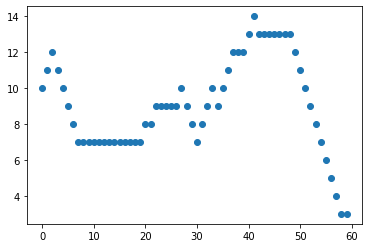

In [90]:
plt.plot(pos[:t, 0], 'o')

# Q-table

In [14]:
class Qtable_constraints:
    
    def __init__(self, state_space, action_space, alpha, gamma, egreedy):
        
        self.state_space = state_space
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.egreedy = egreedy
        
        self.Q = np.zeros([self.state_space, self.action_space])
        self.V = np.zeros(self.state_space)
        
        
    def act(self, s):
        
        if np.random.rand() < self.egreedy:
            a = np.argmax(np.random.randn(1,self.action_space))            
        else:
            a = np.argmax(self.Q[s,:])
          
        return a
      
    def update_Q(self, s, s1, a, r):        
        #Update Q-Table with new knowledge
        self.Q[s,a] = self.Q[s,a] + self.alpha*(r + self.gamma*np.max(self.Q[s1,:]) - self.Q[s,a])
        
    def update_V(self, s, reward):        
        self.V[s] = self.V[s] + reward

In [189]:
#%% ---------------------------------------------------------------------------
# Parameters
# -----------------------------------------------------------------------------
episodes = 1000
time_ep = 10000
# Learning_parameters
learning_rate = 0.01
egreedy = 1
egreedy_decay = 0.999
egreedy_min = 0.1

penalization = 0.5

time_bins = min(time_ep, 1000)
state_space = np.linspace(0, time_ep, time_bins)

In [190]:
agent = Qtable_constraints(state_space = time_bins,
                           action_space = 2,
                           alpha = 0.8, 
                           gamma = 0.95, 
                           egreedy= egreedy)


T = int(1e2)
env = discrete_env(L = 200, boundary_condition='periodic')
tg = env.target_position.clone()

In [209]:
rewards = []
time_to_reward = []
step_length = []
pos_agent = np.zeros((episodes, time_ep, 2))


for e in tqdm(range(episodes)):
    
    env.init_env(target_position = tg)
    
    current_t = 0
    tr = []
    
    current_step = 0
    sl = []
    
    
    for t in (range(time_ep)):
        current_t += 1
        
        pos_agent[e, t, :] = env.agent_pos.clone()
    
        state = np.argwhere((state_space - env.agent_state) <= 0)[-1]

        action = agent.act(state)
        env.update_pos(action)
        state = env.agent_state
        
        # Check step lengths
        current_step += 1
        if action == 1:
            sl.append(current_step)
            current_step = 0
        
        
        reward = env.check_encounter()
        reward -= penalization*current_step
        
        # update q-matrix
        next_state = np.argwhere((state_space - state) <= 0)[-1]
        agent.update_Q(state, next_state, action, reward)            
        agent.update_V(next_state, reward) 
        
        if agent.egreedy > egreedy_min:
            agent.egreedy *= egreedy_decay
            
        if reward > 0:            
            rewards.append(1)
            tr.append(current_t)
            current_t = 0 

    time_to_reward.append(tr)
    step_length.append(sl)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

In [202]:
sum_te = []
for te in time_to_reward[:e]:
    sum_te.append(len(te))

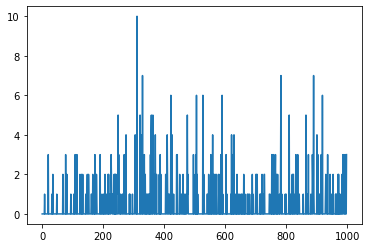

In [203]:
plt.plot(sum_te)

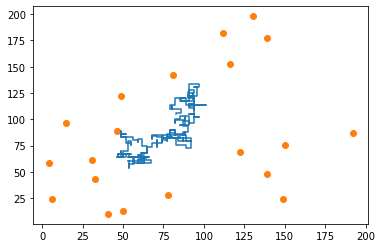

In [206]:
plt.plot(pos_agent[e,:,0], pos_agent[e,:,1])
plt.scatter(env.target_position[:,0], env.target_position[:,1], c = 'C1')

tensor([ 38, 177,  33,  11,  77,  45, 114,  39,  82,  97, 117,  61, 172, 114,
         40,   6, 180,  48,  41,  72])

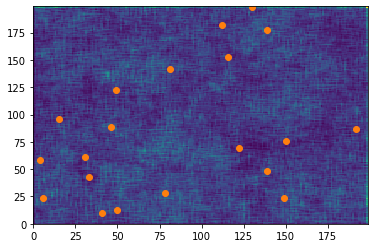

In [205]:
plt.hist2d(pos_agent[:,:,0].flatten(), pos_agent[:,:,1].flatten(), bins = np.arange(0, 200));
plt.scatter(env.target_position[:,0], env.target_position[:,1], c = 'C1')

In [204]:
plt.plot(np.array(rewards).reshape(int(episodes/10),10).mean(1))

ValueError: cannot reshape array of size 505 into shape (100,10)

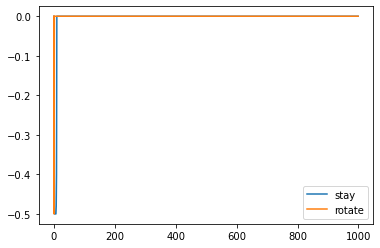

In [208]:
plt.plot(agent.Q[:, 0], label = 'stay');
plt.plot(agent.Q[:, 1], label = 'rotate');
# plt.xlim(1, 200)
plt.legend()

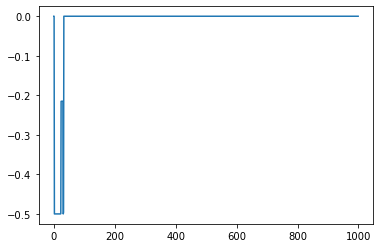

In [152]:
plt.plot(agent.Q[:, 0], label = 'rotate');

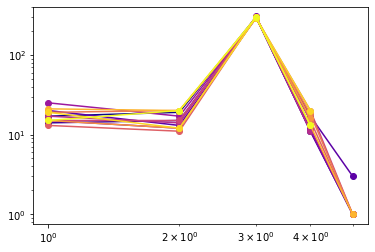

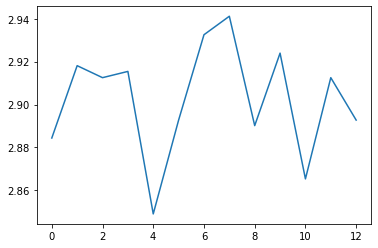

In [207]:
step = 80
colors=plt.cm.plasma(np.linspace(0,1,len(step_length[0:-1:step])))
m = []
for c, ste in zip(colors, step_length[0:-1:step]):
    bn = np.bincount(ste)[1:]
    plt.loglog(np.arange(1, len(bn)+1), bn, 'o-', c = c,)
    m.append(np.mean(ste))

# plt.xlim(0.9, 100)
plt.show()

plt.plot(m)

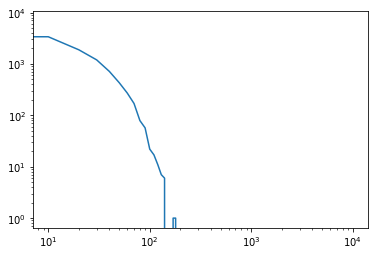

In [131]:
plt.loglog(state_space, agent.V)

## Inference trajectory

In [ ]:
agent.egreedy = 0
T = 100
pos = np.zeros((T, 2))

for t

# Q-Network

In [5]:
class QNAgent:
    def __init__(self, state_size, model, criterion, 
                 optimizer, device, egreedy, egreedy_decay, 
                 egreedy_min, gamma):       
        
        # Input size
        self.state_size = state_size

        # Output size
        self.constraints_size = constraints_size
        self.action_size = self.constraints_size 
        
        
        # Parameters
        self.memory = deque(maxlen=10000)
        self.gamma = gamma    # discount rate
        self.epsilon = egreedy  # exploration rate
        self.epsilon_min = egreedy_min
        self.epsilon_decay = egreedy_decay
        self.model = model   
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
        
    def remember(self, state, action, reward, next_state, done):      
        
        info = [torch.FloatTensor(state).reshape(1, self.state_size).to(self.device), 
                torch.tensor([action], device = self.device), 
                torch.FloatTensor([reward]).to(self.device), 
                torch.FloatTensor(next_state).reshape(1, self.state_size).to(self.device), 
                done]
        self.memory.append(self.Transition(*info))
        
    def act(self, state):        
        state = torch.FloatTensor(state).reshape(1, self.state_size).to(self.device)
        
        if np.random.rand() <= self.epsilon:            
            action = random.randrange(self.constraints_size)                                     
            return action
                
        action = int(torch.argmax(self.model(state)))
        
        return action
    
            
    def replay(self, batch_size):    
        transitions = random.sample(self.memory, batch_size)        
        batch = self.Transition(*zip(*transitions))    
        
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.done)), 
                                      device=self.device, dtype=torch.uint8)        
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                        if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        state_action_values = self.model(state_batch).gather(1, action_batch.reshape(batch_size, 1))

        next_state_values = reward_batch

        next_state_values[non_final_mask] = self.model(non_final_next_states).max(1)[0].detach()* self.gamma + reward_batch[non_final_mask]        
                
        # Optimize the model
        self.optimizer.zero_grad()
        loss = self.criterion(state_action_values, next_state_values.unsqueeze(1))
        loss.backward()
        self.optimizer.step()    
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 3*state_size)
        self.fc2 = nn.Linear(3*state_size, 2*action_size)
        self.fc3 = nn.Linear(2*action_size, 2*action_size)
        self.fc4 = nn.Linear(2*action_size, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x